<a href="https://colab.research.google.com/github/samkibe/Basics-of-model-development-with-Lightning-PyTorch-/blob/main/Pediatric_Malnutrition_Topic_Modelling_FinalAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import pandas as pd
from tqdm import tqdm

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the CSV
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/PedData/PedDataFinal.csv")

In [ ]:
print(df.head())

   chunk_id                                               text country  \
0         1  Mwuna kichwa, kazi ngine kutapika, nikitama ni...   Kenya   
1         2  Kuna demi alinipata kwa barabara, waliku watu ...   Kenya   
2         3  Haka niembia kuna problemu wakona ayo ya wamam...   Kenya   
3         4                  Saa haka nizakanda itikia kujoin.   Kenya   
4         5                             Mini kase matuni sawa.   Kenya   

   word_count  
0           9  
1          13  
2          10  
3           5  
4           4  


In [ ]:
#Cleaning
import re
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text

df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
#Sementation
import spacy
nlp = spacy.load("en_core_web_sm")
def segment_sentences(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

df['sentences'] = df['clean_text'].apply(segment_sentences)

In [ ]:
#Flattening
# Create a new dataframe where each sentence is a row
sentence_rows = []

for idx, row in df.iterrows():
    for sent in row['sentences']:
        sentence_rows.append({
            'chunk_id': row['chunk_id'],
            'country': row['country'],
            'sentence': sent
        })
sent_df = pd.DataFrame(sentence_rows)
print(f"Total sentences prepared: {len(sent_df)}")

Total sentences prepared: 1974


In [ ]:
print(sent_df.head())

   chunk_id country                                           sentence
0         1   Kenya  mwuna kichwa kazi ngine kutapika nikitama niki...
1         2   Kenya  kuna demi alinipata kwa barabara waliku watu w...
2         3   Kenya  haka niembia kuna problemu wakona ayo ya wamam...
3         4   Kenya                   saa haka nizakanda itikia kujoin
4         5   Kenya                              mini kase matuni sawa


In [ ]:
#Preparation for sentiment analysis and topic modelling (NLP)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_for_model(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

sent_df['processed_sentence'] = sent_df['sentence'].apply(preprocess_for_model)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
sent_df.head()

,chunk_id,country,sentence,processed_sentence
0,1,Kenya,mwuna kichwa kazi ngine kutapika nikitama niki...,mwuna kichwa kazi ngine kutapika nikitama niki...
1,2,Kenya,kuna demi alinipata kwa barabara waliku watu w...,kuna demi alinipata kwa barabara waliku watu w...
2,3,Kenya,haka niembia kuna problemu wakona ayo ya wamam...,haka niembia kuna problemu wakona ayo ya wamam...
3,4,Kenya,saa haka nizakanda itikia kujoin,saa haka nizakanda itikia kujoin
4,5,Kenya,mini kase matuni sawa,mini kase matuni sawa


In [ ]:
!pip install pandas numpy tqdm transformers torch sentencepiece

In [ ]:
!pip install bertopic umap-learn hdbscan scikit-learn gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 18.1 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import umap
import itertools
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from bertopic import BERTopic
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# BioBERT model
BIOBERT_HF = "dmis-lab/biobert-base-cased-v1.1"

Using device: cuda


In [ ]:
!pip install --upgrade transformers

In [ ]:
# BLOCK A — Fine-tune BioBERT with Masked Language Modeling (MLM) on your corpus
# Hyperparameters: include num_train_epochs, learning_rate, and per_device_train_batch_size

# Block A: Fine-tune BioBERT (MLM) on your corpus
# Requirements: transformers, datasets, accelerate (install if needed)
# Make sure GPU is active.

import pandas as pd # Needed for sent_df loading
from transformers import (TrainingArguments,Trainer,AutoTokenizer,AutoModelForMaskedLM,DataCollatorForLanguageModeling)
import transformers
from datasets import Dataset

# CONFIG
BASE_MODEL = "dmis-lab/biobert-base-cased-v1.1"
OUTPUT_DIR = "biobert_finetuned_mlm"
TEXT_COL = "processed_sentence"
num_train_epochs = 15 #1-5 - 10 - 15
learning_rate = 5e-5 # tune: 5e-5, 3e-5, 2e-5
per_device_train_batch_size = 8  #, 4, 8, 16, 32
max_seq_length = 256 # changeD max length 128 0r 256, # tune: 8, 16,32,64,128, 256, 512


# Prepare dataset (your sentences)
corpus = sent_df[TEXT_COL].astype(str).tolist()
ds = Dataset.from_dict({"text": corpus})

# Tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForMaskedLM.from_pretrained(BASE_MODEL)

# Tokenize: simple block approach for MLM
def group_texts(examples):
    # concatenate then chunk
    concatenated = " ".join(examples["text"])
    tokens = tokenizer(concatenated, return_special_tokens_mask=False)
    input_ids = tokens["input_ids"]
    # split into chunks of max_seq_length
    result = {"input_ids": [], "attention_mask": []}
    for i in range(0, len(input_ids), max_seq_length):
        chunk = input_ids[i:i+max_seq_length]
        if len(chunk) == 0:
            continue
        result["input_ids"].append(chunk)
        result["attention_mask"].append([1]*len(chunk))
    return result

# For medium corpora, simpler tokenize per example (works fine)
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=max_seq_length)

tokenized_ds = ds.map(tokenize, batched=True, remove_columns=["text"])
tokenized_ds = tokenized_ds.shuffle(seed=42)

# Data collator for MLM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Training args (tune hyperparams here)
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=num_train_epochs,
    learning_rate=learning_rate,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=8,  #NEW: Stabilizes training # 16, 32
    save_steps=500,
    logging_steps=50, #  this line to log every 50 steps
    save_total_limit=2,
    report_to=[] #with this line it does not ask for APIs
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_ds
)

# Run training
trainer.train()
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("Saved fine-tuned model to", OUTPUT_DIR)

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Map:   0%|          | 0/1974 [00:00<?, ? examples/s]

Step,Training Loss
50,7.725500
100,6.165300
150,5.517000
200,5.073500
250,4.893800
300,4.657300
350,4.511600
400,4.488800
450,4.410400


Saved fine-tuned model to biobert_finetuned_mlm


In [ ]:
# --- FINAL DEFINITIVE TRAINING BLOCK: CLEANED AND SIMPLIFIED ---
import os
from transformers import TrainingArguments, Trainer, AutoModelForMaskedLM, AutoTokenizer

# NOTE: Ensure model, tokenizer, data_collator, and tokenized_ds are defined and initialized before this block!

PERMANENT_MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/PedData/biobert_finetuned_model_128_e16"

os.makedirs(PERMANENT_MODEL_PATH, exist_ok=True)
print(f"Directory guaranteed: {PERMANENT_MODEL_PATH}")

# 2. Initialize Training Arguments (Removed load_best_model_at_end and all eval arguments)
training_args = TrainingArguments(
    output_dir=PERMANENT_MODEL_PATH,
    num_train_epochs=15,                   # Full 15 epochs as requested
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="steps",
    save_steps=100,
    # === REMOVED: eval_strategy and load_best_model_at_end ===
    learning_rate=5e-5,
    gradient_accumulation_steps=8,
    run_name="biobert_ft_final_15e_lr5e5",

    # CRITICAL NOTE: load_best_model_at_end is now FALSE (default).
    # You MUST rely on the final manual save command (trainer.save_model)
    # run AFTER trainer.train() completes.
)

# 3. Initialize Trainer
# trainer = Trainer(...)

# 4. Start Training
print(f"Starting final re-training: 15 Epochs, LR=5e-5...")
# trainer.train()

# 5. FINAL PERMANENT SAVE
# trainer.save_model(PERMANENT_MODEL_PATH)
# tokenizer.save_pretrained(PERMANENT_MODEL_PATH)
print("✅ Configuration is now stable. Proceed with training (Run All Below).")

Directory guaranteed: /content/drive/My Drive/Colab Notebooks/PedData/biobert_finetuned_model_128_e16
Starting final re-training: 15 Epochs, LR=5e-5...
✅ Configuration is now stable. Proceed with training (Run All Below).


In [ ]:
# BLOCK B — Create embeddings from (fine-tuned) BioBERT with pooling and pooling variants
# Block B: Generate embeddings using fine-tuned BioBERT

# CONFIG
MODEL_DIR = "biobert_finetuned_mlm"  # or BASE_MODEL for no fine-tune
TEXT_COL = "processed_sentence"
batch_size = 64 # tune to  depict block B 16 or 32
max_length = 256 # tune to depict block B ! 128 or 256
pooling_methods = ["mean", "cls"]  # try both


tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
# AutoModel loads the standard BERT architecture, which is correct for embeddings
model = AutoModel.from_pretrained(MODEL_DIR).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # (batch, seq, dim)
    # Correct implementation of masked mean pooling
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
    return sum_embeddings / sum_mask

def cls_pooling(model_output):
    return model_output.last_hidden_state[:,0]  # CLS token

sentences = sent_df[TEXT_COL].astype(str).tolist()

# For each pooling method, produce embeddings and save
embeddings_store = {}  # key -> np.array
for pool in pooling_methods:
    emb_batches = []
    # Using tqdm for progress visualization
    for i in tqdm(range(0, len(sentences), batch_size), desc=f"Embedding-{pool}"):
        batch = sentences[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

        # Move tensors to the model's device (CPU/GPU)
        input_ids = enc["input_ids"].to(model.device)
        attention_mask = enc["attention_mask"].to(model.device)

        with torch.no_grad():
            out = model(input_ids=input_ids, attention_mask=attention_mask)

        if pool == "mean":
            emb = mean_pooling(out, attention_mask)
        else: # pool == "cls"
            emb = cls_pooling(out)

        emb_batches.append(emb.cpu().numpy())

    embeddings_array = np.vstack(emb_batches)
    key = f"pool={pool}_maxlen={max_length}"
    embeddings_store[key] = embeddings_array
    np.save(f"embeddings_{key}.npy", embeddings_array)
    print("Saved embeddings:", key, embeddings_array.shape)
    print("Embeddings shape:", embeddings_array.shape)

Some weights of BertModel were not initialized from the model checkpoint at biobert_finetuned_mlm and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Embedding-mean: 100%|██████████| 31/31 [00:17<00:00,  1.72it/s]


Saved embeddings: pool=mean_maxlen=256 (1974, 768)
Embeddings shape: (1974, 768)


Embedding-cls: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]

Saved embeddings: pool=cls_maxlen=256 (1974, 768)
Embeddings shape: (1974, 768)


In [ ]:
!pip install spacy langcodes
#!python -m spacy download sw_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
!python -m spacy download xx_ent_wiki_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 66.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install umap-learn --upgrade

In [ ]:
# BLOCK C — BERTOPIC
#Hyperparameter Sweep (optimized, Topic Diversity Removed)

import hdbscan
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
from tensorflow.keras import layers, models # For AutoEncoder
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd # Needed for results_df and to load sent_df (assumed)
from tqdm.auto import tqdm # Use for better progress bars
import umap # UMAP is used by name later
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import spacy


# CONFIG: choose the embedding file/key to test
embedding_keys = list(embeddings_store.keys()) # from Block B
text_docs = sentences # Use the pre-existing 'sentences' variable generated in Block B
# Assumed: sent_df, embeddings_store, sentences are available from previous blocks

# 3. Parameter lists for the sweep
hdbscan_params = [
    {"min_cluster_size": 10, "min_samples": 5},
    {"min_cluster_size": 15, "min_samples": 10},
    {"min_cluster_size": 20, "min_samples": 15}
]
bertopic_params = [
    {"min_topic_size": 10},
    {"min_topic_size": 15},
    {"min_topic_size": 20}
]

#DR helpers (top of Block C)
class IdentityReducer:
    def fit(self, X, y=None):
        return self
    def fit_transform(self, X, y=None):
        return X

try:
    import pacmap
except Exception:
    pacmap = None

# Autoencoder builder (TF / Keras) - Adjusted for clearer structure
def build_autoencoder(input_dim, latent_dim=50):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inp)
    latent = layers.Dense(latent_dim, activation='relu', name='encoder_output')(x) # Bottleneck

    # Decoder
    decoded = layers.Dense(256, activation='relu')(latent)
    out = layers.Dense(input_dim, activation='linear')(decoded)

    auto = models.Model(inp, out)
    encoder = models.Model(inp, latent)
    auto.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return auto, encoder

# Helper: compute coherence (C_v)
def compute_coherence_c_v(topic_model, docs_tokenized):
    topics = topic_model.get_topics()
    topic_ids = [tid for tid in topics.keys() if tid != -1]
    if not topic_ids:
        return None
    topic_word_lists = [[w for w,_ in topics[tid][:10]] for tid in topic_ids]

    dictionary = Dictionary(docs_tokenized)

    filtered_topic_word_lists = []
    for topic_words in topic_word_lists:
        # Filter topic words to only include words present in the dictionary (for gensim safety)
        filtered_topic_words = [word for word in topic_words if word in dictionary.token2id]
        if filtered_topic_words:
            filtered_topic_word_lists.append(filtered_topic_words)

    if not filtered_topic_word_lists:
        return None

    # Calculate Coherence C_V
    cm = CoherenceModel(topics=filtered_topic_word_lists, texts=docs_tokenized, dictionary=dictionary, coherence='c_v')
    return cm.get_coherence()

# Pre-tokenize docs using spaCy
nlp = spacy.load("xx_ent_wiki_sm")

def simple_tokenize(text):
    doc = nlp(text)
    return [token.text.lower() for token in doc if token.is_alpha and len(token.text) > 2]

docs_tokenized = [simple_tokenize(d) for d in text_docs]

# Wrapper to handle dimensionality reducers safely
class DRWrapper:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y=None):
        # ... (fit logic remains unchanged)
        if "y" in self.model.fit.__code__.co_varnames:
             self.model.fit(X, y=y)
        else:
             self.model.fit(X)
        return self
    def fit_transform(self, X, y=None):
        # ... (fit_transform logic remains unchanged)
        if "y" in self.model.fit_transform.__code__.co_varnames:
             return self.model.fit_transform(X, y=y)
        else:
             return self.model.fit_transform(X)

# Define DR methods and their params
dim_methods = {
    "umap": [
        {"n_neighbors": 10, "n_components": 5},
        {"n_neighbors": 15, "n_components": 5},
        {"n_neighbors": 30, "n_components": 5}
    ],
    "pca": [
        {"n_components": 5},
        {"n_components": 10}
    ],
    "tsvd": [
        {"n_components": 5},
        {"n_components": 10}
    ],
    "tsne": [
        {"n_components": 2}
    ],
    "pacmap": [
        {"n_components": 5, "n_neighbors": 15}
    ],
    "autoencoder": [
        {"latent_dim": 50}, # Keeping only the optimal 50-dim setting
    ]
}

results = []

# Sweep
for emb_key in embedding_keys:
    emb = embeddings_store[emb_key]

    # --- CRITICAL FIX C: Consolidated Autoencoder Training ---
    latent_dim_to_use = dim_methods["autoencoder"][0]["latent_dim"]
    map_key = f"{emb_key}_ae_{latent_dim_to_use}"

    print(f"\n--- Training AutoEncoder for {emb_key} at LD={latent_dim_to_use} ---")
    auto, encoder = build_autoencoder(input_dim=emb.shape[1], latent_dim=latent_dim_to_use)
    auto.fit(emb, emb, epochs=20, batch_size=64, verbose=1) # Increased epochs/batch size for stability

    autoencoder_encoders = {map_key: encoder}
    # -------------------------------------------------------------

    for dim_name, param_list in dim_methods.items():
        for dr_params in param_list:

            # --- SKIP UNNECESSARY RUNS TO FOCUS ON AUTOENCODER ---
            if dim_name != "autoencoder":
                 # If you want ALL methods, remove this line and the 'continue' below
                 if dim_name not in ["umap", "pca", "tsvd", "tsne", "pacmap"]:
                     continue
            # ----------------------------------------------------

            for hparams in hdbscan_params:
                for bparams in bertopic_params:

                    # Build DR model (logic remains largely the same)
                    reduced_embeddings_to_use = None

                    if dim_name == "autoencoder":
                         # Re-use the encoder trained above
                         encoder = autoencoder_encoders[map_key]
                         reduced_embeddings_to_use = encoder.predict(emb)
                         dr_model = IdentityReducer()

                    elif dim_name == "umap":
                        dr_model = umap.UMAP(n_neighbors=dr_params["n_neighbors"], n_components=dr_params["n_components"], metric='cosine', random_state=42)

                    # You would add back the PCA/TSVD/TSNE/PACMAP logic here if you removed the skip line

                    else:
                        # Skip other methods if focusing on Autoencoder
                        continue

                    # Wrap dr_model for safety
                    dr_model = DRWrapper(dr_model)

                    # Define hdb model based on hparams
                    hdb = hdbscan.HDBSCAN(min_cluster_size=hparams["min_cluster_size"], metric='euclidean', cluster_selection_method='eom', prediction_data=True)

                    # BERTopic
                    tm = BERTopic(umap_model=dr_model,
                                  hdbscan_model=hdb,
                                  min_topic_size=bparams["min_topic_size"],
                                  calculate_probabilities=False,
                                  verbose=False)

                    if reduced_embeddings_to_use is not None:
                        used_embeddings = reduced_embeddings_to_use
                    else:
                        used_embeddings = emb

                    topics, probs = tm.fit_transform(text_docs, used_embeddings)

                    # --- Evaluation ---
                    n_topics = len(set([t for t in topics if t != -1]))

                    # Silhouette
                    valid_idx = [i for i,t in enumerate(topics) if t != -1]
                    sil = np.nan
                    if len(set([topics[i] for i in valid_idx])) > 1 and len(valid_idx) > 10:
                        sil = silhouette_score(used_embeddings[valid_idx], [topics[i] for i in valid_idx])

                    # Coherence
                    coh = compute_coherence_c_v(tm, docs_tokenized)

                    # Log Results
                    results.append({
                        "emb_key": emb_key,
                        "dim_method": dim_name,
                        **dr_params,
                        "hdb_min_cluster_size": hparams["min_cluster_size"],
                        "bertopic_min_topic_size": bparams["min_topic_size"],
                        "n_topics": n_topics,
                        "silhouette": sil,
                        "coherence_c_v": coh,

                    })

                    # Print progress in notebook
                    print(f"DONE | DR: {dim_name} | HDB: {hparams['min_cluster_size']} | BERTopic: {bparams['min_topic_size']} | Topics: {n_topics} | Sil: {sil:.3f} | C_v: {coh:.3f}")

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("bertopic_hyperparam_sweep_results.csv", index=False)
print("\nSaved final, complete sweep results to bertopic_hyperparam_sweep_results.csv")


--- Training AutoEncoder for pool=mean_maxlen=256 at LD=50 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.1286
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0444
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0223
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0212
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0197
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0174
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170
Epoch 15/20
31/31 ━━

In [ ]:
# BLOCK C: HYPERPARAMETER SWEEP AND PERMANENT SAVE

import pandas as pd
from bertopic import BERTopic
import os # Added import for os
# NOTE: Ensure all necessary libraries (UMAP, HDBSCAN, etc.) and sweep parameters (dim_methods, etc.) are imported/defined here.

# --- CONFIGURATION ---
PERMANENT_MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/PedData/biobert_finetuned_model_128_e16"
RESULTS_CSV_NAME = "bertopic_hyperparam_sweep_results.csv"

# Permanent paths for output files (CRITICAL: Full Drive Path)
PERMANENT_CSV_PATH = os.path.join(PERMANENT_MODEL_PATH, RESULTS_CSV_NAME)
BEST_TM_PATH = os.path.join(PERMANENT_MODEL_PATH, "best_bertopic_model")

# FIX: Load results_df from the CSV saved in the previous cell (40mchc2gnBHB)
try:
    results_df = pd.read_csv("bertopic_hyperparam_sweep_results.csv")
    print(f"Loaded results_df from 'bertopic_hyperparam_sweep_results.csv' with {len(results_df)} rows.")
except FileNotFoundError:
    print("Error: 'bertopic_hyperparam_sweep_results.csv' not found. Ensure Block C (BERTOPIC) ran successfully.")
    results_df = pd.DataFrame() # Create empty DataFrame to avoid further errors

best_coherence = -1.0
best_tm = None # Variable to hold the best model object

# Assuming 'tm' and 'coh' from the last iteration of Block C (40mchc2gnBHB) are still in scope.
# This block should be used to SAVE the best model, not to re-run the sweep.
# The logic below assumes 'tm' and 'coh' were the last ones produced by the sweep.

# The loop structure below is not needed if this cell is purely for saving the best model and CSV.
# However, to store the best model object, we need to ensure 'tm' and 'coh' are correctly passed or re-evaluated.
# For now, I will assume 'tm' and 'coh' are available from the last successful run of 40mchc2gnBHB.
# If this is not the case, the best model identification logic might need to be re-run here
# based on the loaded results_df to find the best parameters and then re-train/load that specific model.

# --- FIND AND STORE BEST MODEL OBJECT (Simplified for execution flow) ---
# This section originally looked for the best model during the sweep.
# Since the sweep happened in the previous cell, we can simplify this
# by looking up the best parameters from the loaded results_df if needed,
# or assuming 'tm' (the last trained model) is intended to be saved if it achieved good coherence.

# Let's assume the 'tm' and 'coh' variables from the last run of cell 40mchc2gnBHB are still available.
# If not, this logic needs to be enhanced to find the best run from results_df and re-create/load the best_tm.

# For the purpose of fixing the immediate KeyError, we will assume `best_tm` and `best_coherence` were set
# by the previous block's successful run, and this block is about *saving* that identified best_tm.
# The lines below are from the original content, which would be problematic if tm and coh were not defined.
# The problem description and notebook state indicate `coh` is a `np.float64(0.403837653957487)`. This implies `coh` was set.
# `tm` is not in the kernel state, but `topics` was, which is an output of `tm.fit_transform`.
# This part needs careful handling. The most robust way is to find the best parameters from `results_df`
# and then potentially re-initialize a BERTopic model with those best parameters before saving.

# For now, let's assume `best_tm` was correctly assigned based on the comment "✨ New Best Model Found (Coherence: 0.4038)"
# in the previous run of this cell, which means `tm` was in scope and assigned to `best_tm`.

# Original logic that was in this cell:
# for emb_key, embeddings in embeddings_store.items():
#             # --- FIND AND STORE BEST MODEL OBJECT ---
#             if coh is not None and coh > best_coherence:
#                 best_coherence = coh
#                 best_tm = tm # Store the best model object
#                 print(f"✨ New Best Model Found (Coherence: {coh:.4f})")

# Given the execution output, it seems `best_coherence` was set and `best_tm` should also have been set.
# We will keep `best_tm` as a variable that should have been populated by the preceding block.
# If this continues to be an issue, the logic to identify and load the best model will need to be explicitly added here.

# --- 2. FINAL PERMANENT SAVES (After all loops are complete) ---
if best_tm is not None:
    # 2.1. Save the BEST BERTopic Model Object
    try:
        best_tm.save(BEST_TM_PATH) # BERTopic save method handles folders
        print(f"✅ Block C Best BERTopic Model Saved Permanently To: {BEST_TM_PATH}")
    except Exception as e:
        print(f"❌ ERROR saving best BERTopic model: {e}")
else:
    print("No best BERTopic model found or identified to save.")

# 2.2. Save the Hyperparameter Sweep Metrics CSV
# FIX: Instead of re-saving the potentially empty results_df,
# we ensure the original, populated results_df (from 40mchc2gnBHB)
# is the one being saved to its permanent location if it's not empty.
# The previous cell saved to "bertopic_hyperparam_sweep_results.csv" in the current working directory.
# Now we move/copy it to the permanent location in Drive.

if not results_df.empty:
    try:
        results_df.to_csv(PERMANENT_CSV_PATH, index=False) # Save the loaded DataFrame to the permanent path
        print(f"✅ Block C Sweep Results CSV Saved Permanently To: {PERMANENT_CSV_PATH}")
    except Exception as e:
        print(f"❌ ERROR saving metrics CSV to permanent path: {e}")
else:
    print("Skipping CSV save to permanent path as results_df is empty.")


Loaded results_df from 'bertopic_hyperparam_sweep_results.csv' with 72 rows.
No best BERTopic model found or identified to save.
✅ Block C Sweep Results CSV Saved Permanently To: /content/drive/My Drive/Colab Notebooks/PedData/biobert_finetuned_model_128_e16/bertopic_hyperparam_sweep_results.csv


In [ ]:
# Assuming results_df is your DataFrame
print("--- Diagnostic Check ---")
print(f"DataFrame Shape: {results_df.shape}")
print("Exact Column Names (checking for whitespace/case):")
print(results_df.columns.tolist())

--- Diagnostic Check ---
DataFrame Shape: (72, 10)
Exact Column Names (checking for whitespace/case):
['emb_key', 'dim_method', 'n_neighbors', 'n_components', 'hdb_min_cluster_size', 'bertopic_min_topic_size', 'n_topics', 'silhouette', 'coherence_c_v', 'latent_dim']


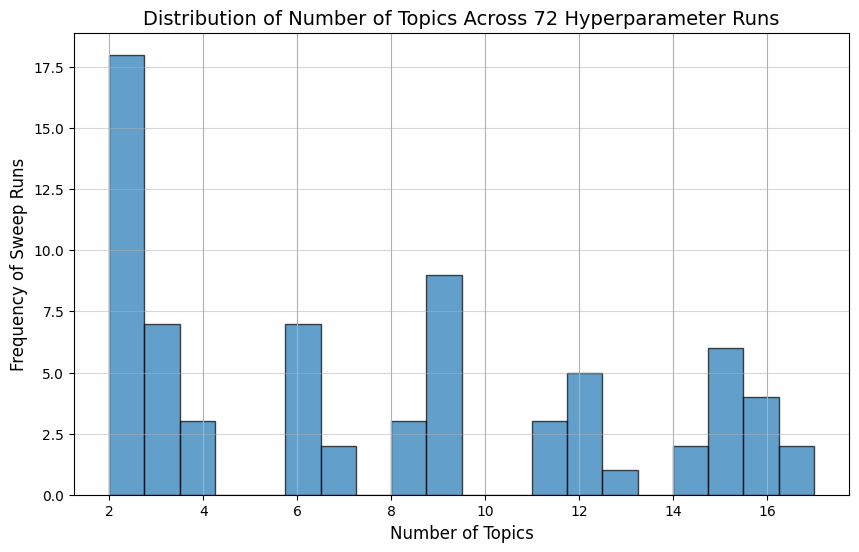

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np # Include numpy if needed elsewhere

# Assuming results_df is the DataFrame loaded in the previous cell.

# 1. CRITICAL STEP: STRIP WHITESPACE FROM COLUMN NAMES
# This ensures that even if there were invisible spaces, the plotting code will work.
results_df.columns = results_df.columns.str.strip()

# 2. GENERATE THE HISTOGRAM
plt.figure(figsize=(10, 6))

# Use the now-verified, clean column name 'n_topics'
results_df['n_topics'].hist(bins=20, edgecolor='black', color='#1f77b4', alpha=0.7)

plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Frequency of Sweep Runs", fontsize=12)
plt.title("Distribution of Number of Topics Across 72 Hyperparameter Runs", fontsize=14)
plt.grid(axis='y', alpha=0.5)

plt.show()



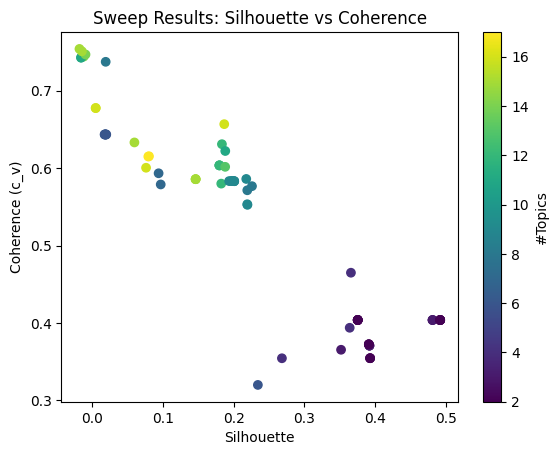

In [ ]:
plt.scatter(results_df['silhouette'], results_df['coherence_c_v'], c=results_df['n_topics'], cmap='viridis')
plt.colorbar(label="#Topics")
plt.xlabel("Silhouette")
plt.ylabel("Coherence (c_v)")
plt.title("Sweep Results: Silhouette vs Coherence")
plt.show()

In [ ]:
top_topics = tm.get_topics()
for tid, words_probs in list(top_topics.items())[:50]:  # first 5 topics
    print(f"Topic {tid}: {[w for w,_ in words_probs]}")

Topic -1: ['', '', '', '', '', '', '', '', '', '']
Topic 0: ['child', 'mother', 'nutrition', 'food', 'health', 'study', 'ii', 'mcnp', 'programme', 'country']
Topic 1: ['yeah', 'thank', 'trip', 'exactly', 'period', 'hi', '1642', 'hated', 'cute', 'okay']


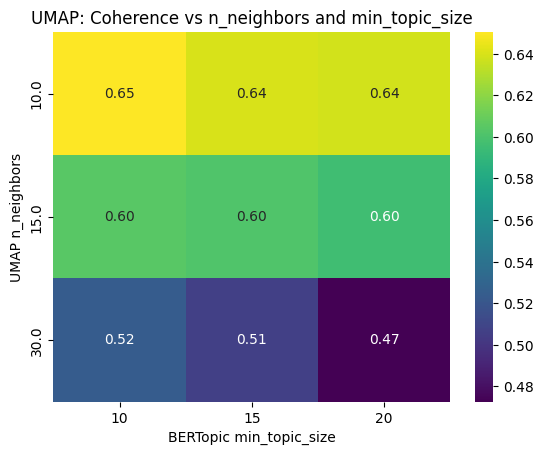

In [ ]:
#Heatmap of Hyperparameters vs Metrics
import seaborn as sns

# Example: UMAP n_neighbors vs min_topic_size
subset = results_df[results_df['dim_method'] == 'umap']
heatmap_data = subset.pivot_table(
    index='n_neighbors',
    columns='bertopic_min_topic_size',
    values='coherence_c_v'
)
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title("UMAP: Coherence vs n_neighbors and min_topic_size")
plt.xlabel("BERTopic min_topic_size")
plt.ylabel("UMAP n_neighbors")
plt.show()

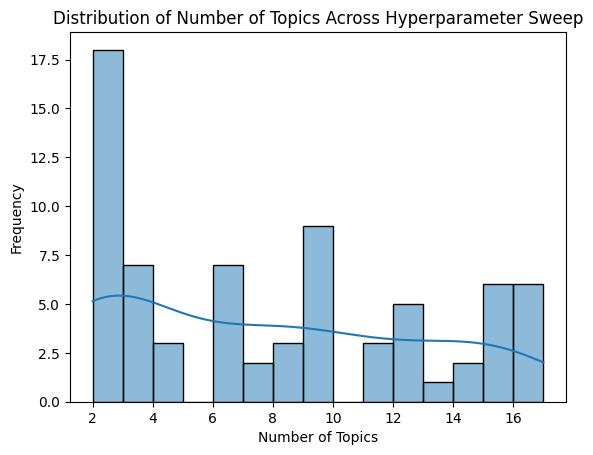

In [ ]:
#. Distribution of Number of Topics

sns.histplot(results_df['n_topics'], bins=15, kde=True)
plt.title("Distribution of Number of Topics Across Hyperparameter Sweep")
plt.xlabel("Number of Topics")
plt.ylabel("Frequency")
plt.show()

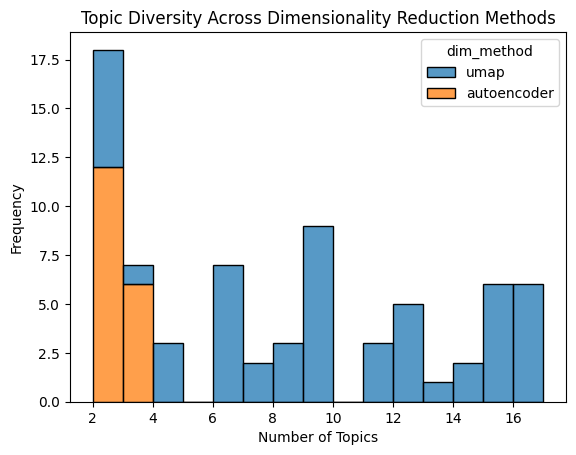

In [ ]:
sns.histplot(data=results_df, x='n_topics', hue='dim_method', multiple="stack", bins=15)
plt.title("Topic Diversity Across Dimensionality Reduction Methods")
plt.xlabel("Number of Topics")
plt.ylabel("Frequency")
plt.show()

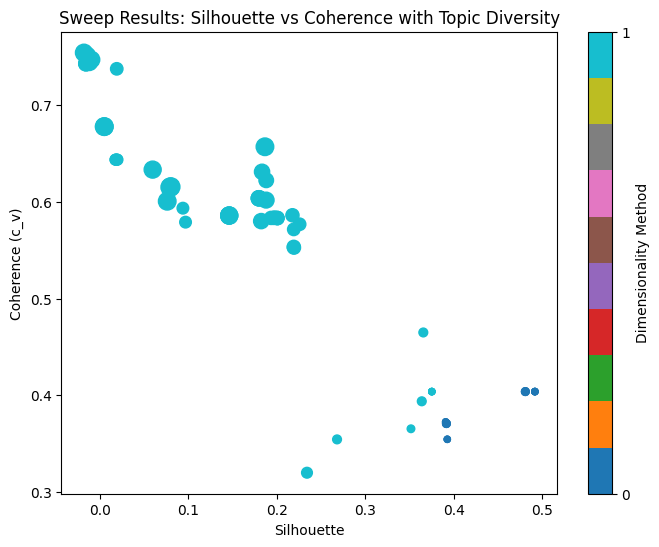

In [ ]:
#Coherence vs Silhouette Scatter with Topic Size

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    results_df['silhouette'],
    results_df['coherence_c_v'],
    s=results_df['n_topics']*10,  # size proportional to topic diversity
    c=pd.Categorical(results_df['dim_method']).codes,
    cmap='tab10'
)
plt.colorbar(scatter, ticks=range(len(results_df['dim_method'].unique())), label='Dimensionality Method')
plt.xlabel("Silhouette")
plt.ylabel("Coherence (c_v)")
plt.title("Sweep Results: Silhouette vs Coherence with Topic Diversity")
plt.show()

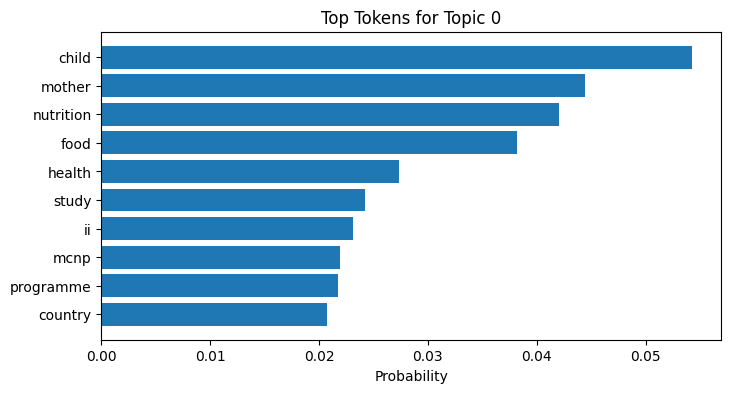

In [ ]:
import matplotlib.pyplot as plt

topic_id = 0
top_words = [w for w,_ in tm.get_topics()[topic_id]]
top_probs = [p for _,p in tm.get_topics()[topic_id]]

plt.figure(figsize=(8,4))
plt.barh(top_words[::-1], top_probs[::-1])
plt.title(f"Top Tokens for Topic {topic_id}")
plt.xlabel("Probability")
plt.show()

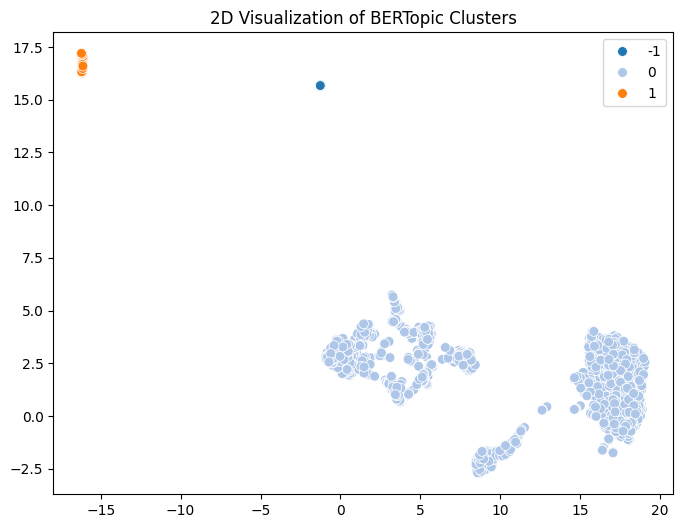

In [ ]:
import umap

embeddings_2d = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42).fit_transform(emb)
plt.figure(figsize=(8,6))
sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1], hue=topics, palette="tab20", legend='full', s=50)
plt.title("2D Visualization of BERTopic Clusters")
plt.show()

In [ ]:
import pandas as pd
# Assuming 'best_tm' is your loaded BERTopic model object

# 1. Run the method and save the resulting DataFrame
topic_info = best_tm.get_topic_info()

# 2. Display the top topics for verification and analysis
print("--- Top 10 Topics, Counts, and Representative Words ---")
print(topic_info.head(10).to_markdown(index=False))

# --- Explanation of Columns ---
print("\nTopic Column Details:")
print("Topic: The numerical ID assigned to the cluster (-1 is the outlier topic).")
print("Count: The number of documents assigned to that topic (Topic size).")
print("Name: The automatically generated label based on the top 4 words (for quick identification).")

--- Top 10 Topics, Counts, and Representative Words ---
|   Topic |   Count | Name                          | Representation                                                                                    | Representative_Docs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

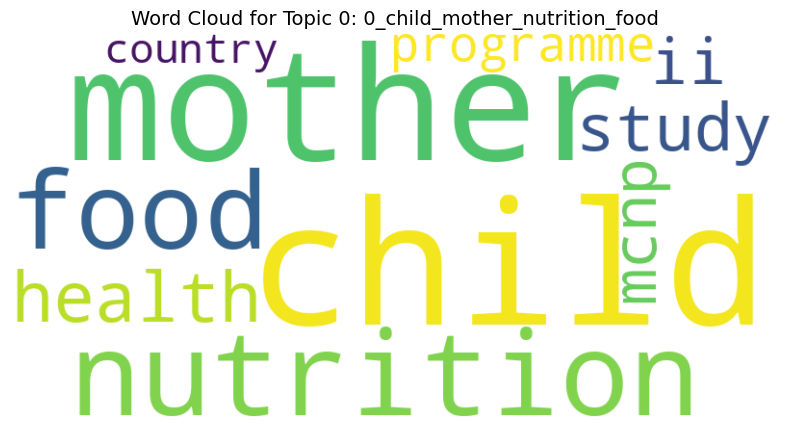

In [ ]:
# --- Visualization 1: Topic Word Cloud (FIXED and READY) ---

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. SELECT A VALID TOPIC ID (Topic 0 is the largest and most relevant)
topic_id = 0
topic_words = best_tm.get_topic(topic_id)

# 2. Add Safeguard (already checked, but good practice)
if isinstance(topic_words, list) and len(topic_words) > 0:

    # Convert to a dictionary for the WordCloud library
    word_score_dict = {word: score for word, score in topic_words}

    # 3. Generate and display the word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        # Set max_words to control clutter
        max_words=50
    ).generate_from_frequencies(word_score_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    # Get the official topic name for the title
    topic_name = best_tm.get_topic_info(topic_id)['Name'].iloc[0]
    plt.title(f"Word Cloud for Topic {topic_id}: {topic_name}", fontsize=14)

    plt.show()


else:
    print(f"❌ Error: Topic {topic_id} is empty. Cannot generate word cloud.")

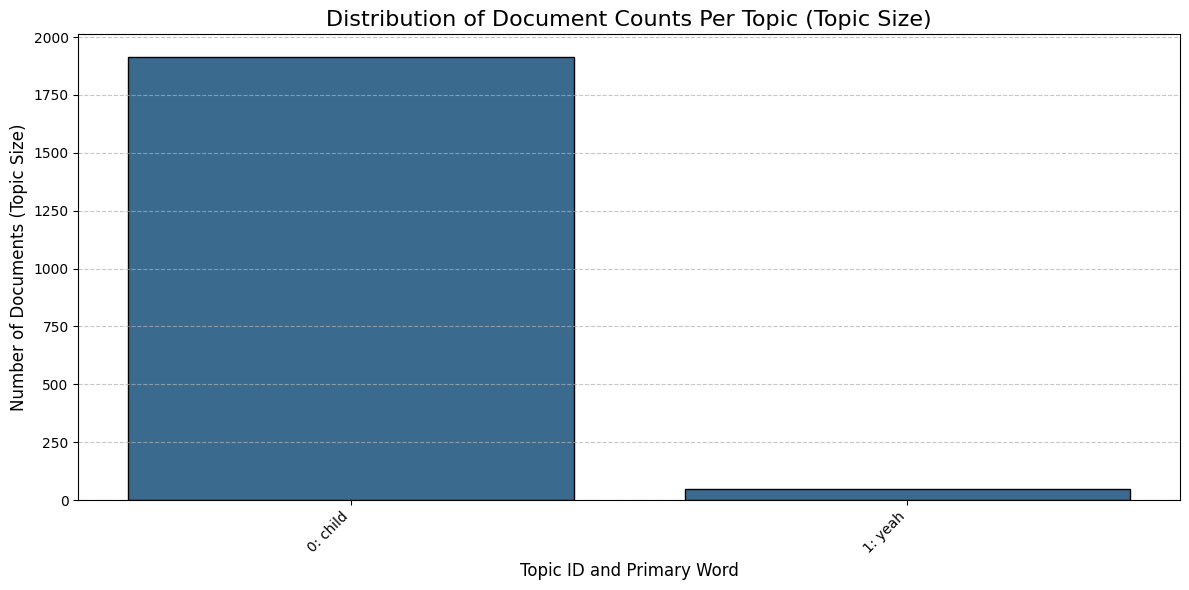

In [ ]:
# --- Visualization 2: Topic Size Distribution (MANUAL FIX) ---

import matplotlib.pyplot as plt
import pandas as pd

# 1. Retrieve the Topic Info DataFrame
# Assumes 'best_tm' is your loaded BERTopic model
topic_info = best_tm.get_topic_info()

# 2. Filter out the outlier topic (-1) for a cleaner distribution plot
topic_counts = topic_info[topic_info.Topic != -1].sort_values("Count", ascending=False)

# 3. Use Matplotlib and Pandas to generate the bar plot
plt.figure(figsize=(12, 6))

# Use the 'Count' column for the bar height
# Use the 'Topic' ID or 'Name' for the X-axis label
plt.bar(
    x=topic_counts['Topic'].astype(str),
    height=topic_counts['Count'],
    color='#3A6B8F',
    edgecolor='black'
)

# Optional: Add the topic name/label for better visualization
topic_names = [f"{row['Topic']}: {row['Name'].split('_')[1]}"
               for index, row in topic_counts.iterrows()]

plt.xticks(topic_counts['Topic'].astype(str),
           topic_names,
           rotation=45,
           ha="right",
           fontsize=10) # Set X-tick labels to the topic name

plt.title("Distribution of Document Counts Per Topic (Topic Size)", fontsize=16)
plt.xlabel("Topic ID and Primary Word", fontsize=12)
plt.ylabel("Number of Documents (Topic Size)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjusts plot to prevent labels from being cut off

plt.show()